In [1]:
import pandas as pd

# Carregando o arquivo que está na mesma pasta do notebook
# O nome do arquivo dentro das aspas deve ser IDÊNTICO ao nome do arquivo na pasta
nome_do_arquivo = "online_retail_II.csv"

print(f"Lendo o arquivo {nome_do_arquivo}...")
df = pd.read_csv(nome_do_arquivo)

print("Sucesso! Dados carregados.")
df.head()

Lendo o arquivo online_retail_II.csv...
Sucesso! Dados carregados.


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [2]:
# 1. Ver informações gerais (tipos de dados e contagem de não-nulos)
print("--- Informações do Dataset ---")
df.info()

# 2. Contar quantos valores vazios (NaN) existem em cada coluna
print("\n--- Valores Faltando por Coluna ---")
print(df.isnull().sum())

--- Informações do Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB

--- Valores Faltando por Coluna ---
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


In [3]:
# 1. Removendo linhas onde 'Customer ID' está vazio
df = df.dropna(subset=['Customer ID'])

# 2. Removendo devoluções (Quantidades negativas)
df = df[df['Quantity'] > 0]

# 3. Transformando 'Customer ID' de número decimal (13085.0) para inteiro (13085)
df['Customer ID'] = df['Customer ID'].astype(int)

# 4. Garantindo que a data seja lida corretamente pelo Python
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 5. Criando a coluna de Valor Total (Monetário)
df['TotalPay'] = df['Quantity'] * df['Price']

print("Limpeza concluída!")
print(f"Novo tamanho do dataset: {df.shape[0]} linhas")
df.head()

Limpeza concluída!
Novo tamanho do dataset: 805620 linhas


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPay
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [4]:
# Verificando a data mais antiga e a mais recente
print("Data Inicial:", df['InvoiceDate'].min())
print("Data Final:", df['InvoiceDate'].max())

Data Inicial: 2009-12-01 07:45:00
Data Final: 2011-12-09 12:50:00


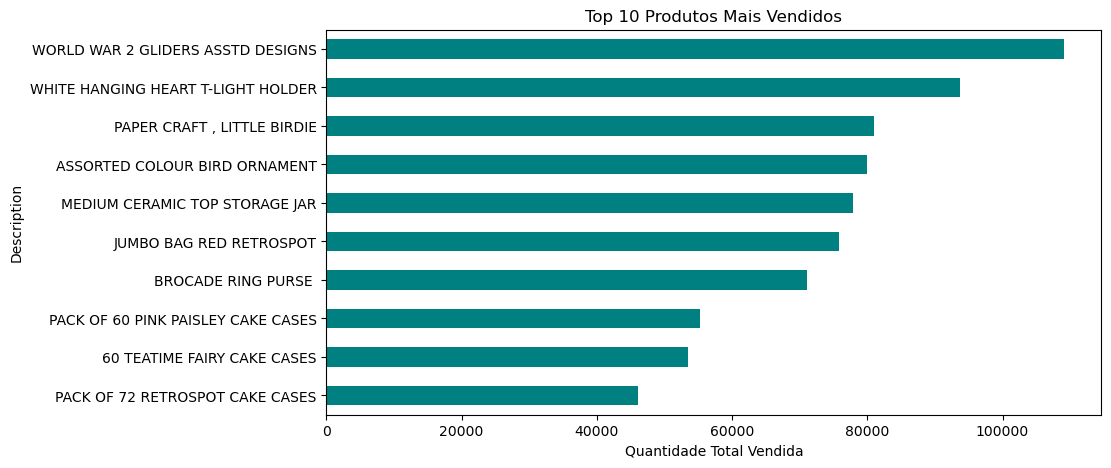

In [5]:
import matplotlib.pyplot as plt

# Agrupando por descrição do produto e somando a quantidade
top_produtos = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Criando um gráfico de barras horizontais
plt.figure(figsize=(10, 5))
top_produtos.sort_values(ascending=True).plot(kind='barh', color='teal')
plt.title('Top 10 Produtos Mais Vendidos')
plt.xlabel('Quantidade Total Vendida')
plt.show()

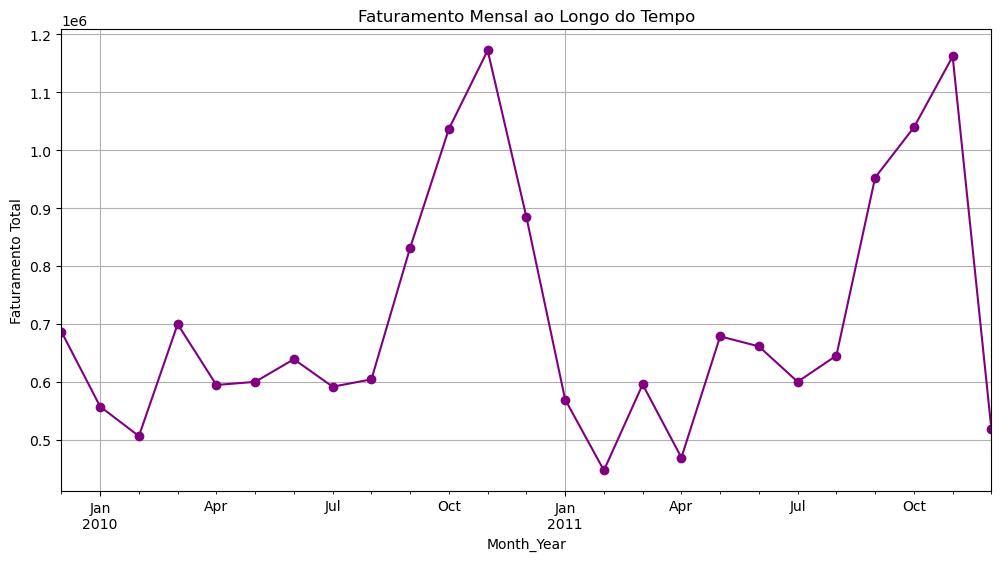

In [6]:
# Criando uma coluna apenas com o Mês (Para facilitar o agrupamento)
# O código abaixo extrai o "Ano-Mês" da data
df['Month_Year'] = df['InvoiceDate'].dt.to_period('M')

# Somando o faturamento (TotalPay) por mês
vendas_mensais = df.groupby('Month_Year')['TotalPay'].sum()

# Plotando o gráfico de linha
plt.figure(figsize=(12, 6))
vendas_mensais.plot(marker='o', linestyle='-', color='purple')
plt.title('Faturamento Mensal ao Longo do Tempo')
plt.ylabel('Faturamento Total')
plt.grid(True)
plt.show()

In [7]:
# 1. Definir a data de referência (O "Hoje" da análise)
# Pegamos a data máxima do dataset e somamos 1 dia
data_atual = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Data de Referência para análise: {data_atual}")

# 2. Criar a tabela RFM agrupando por cliente
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (data_atual - x.max()).days, # Recência: Dias desde a última compra
    'Invoice': 'nunique',                                 # Frequência: Contagem de pedidos únicos
    'TotalPay': 'sum'                                     # Monetário: Soma do valor gasto
})

# 3. Renomear as colunas para facilitar
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# 4. Apenas para garantir, vamos remover quem tem Monetário <= 0 (pode acontecer por causa de descontos/erros)
rfm = rfm[rfm['Monetary'] > 0]

print("Tabela RFM criada!")
rfm.head()

Data de Referência para análise: 2011-12-10 12:50:00
Tabela RFM criada!


,Recency,Frequency,Monetary
Customer ID,,,
12346,326,12,77556.46
12347,2,8,5633.32
12348,75,5,2019.40
12349,19,4,4428.69
12350,310,1,334.40


In [8]:
# Criando os quartis (dividindo em 4 partes iguais: 25%, 50%, 75%)
quartis = rfm.quantile(q=[0.25, 0.5, 0.75])

# Função para dar nota de Recência (Quanto MENOR o valor, MAIOR a nota)
def score_recencia(x, p, d):
    if x <= d[p][0.25]: return 4
    elif x <= d[p][0.50]: return 3
    elif x <= d[p][0.75]: return 2
    else: return 1

# Função para Frequência e Monetário (Quanto MAIOR o valor, MAIOR a nota)
def score_padrao(x, p, d):
    if x <= d[p][0.25]: return 1
    elif x <= d[p][0.50]: return 2
    elif x <= d[p][0.75]: return 3
    else: return 4

# Aplicando as funções
rfm['R_Score'] = rfm['Recency'].apply(score_recencia, args=('Recency', quartis))
rfm['F_Score'] = rfm['Frequency'].apply(score_padrao, args=('Frequency', quartis))
rfm['M_Score'] = rfm['Monetary'].apply(score_padrao, args=('Monetary', quartis))

# Criando a "Nota Final" (Juntando os números como texto, ex: "444")
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
Customer ID,,,,,,,
12346,326,12,77556.46,2,4,4,244
12347,2,8,5633.32,4,4,4,444
12348,75,5,2019.40,3,3,3,333
12349,19,4,4428.69,4,3,4,434
12350,310,1,334.40,2,1,1,211


In [9]:
def definir_segmento(row):
    r = row['R_Score']
    f = row['F_Score']

    # Lógica de Segmentação (Simplificada para Iniciantes)

    # 1. CAMPEÕES: Compraram recentemente (R=4) e compram muito (F=4)
    # Ação: Dê recompensas, eles já amam a marca.
    if r == 4 and f == 4:
        return 'Campeões'

    # 2. FIÉIS: Compram com frequência (F >= 3), mas não necessariamente ontem.
    # Ação: Mantenha engajados.
    elif f >= 3:
        return 'Fiéis'

    # 3. NOVOS PROMISSORES: Compraram recentemente (R=4), mas poucas vezes (F=1).
    # Ação: Precisam de um empurrão para a segunda compra (Onboarding).
    elif r == 4 and f <= 1:
        return 'Novos Promissores'

    # 4. EM RISCO (Churn): Compravam muito (F >= 3) mas sumiram (R <= 2).
    # Ação: URGENTE! Ofereça desconto agressivo para voltar.
    elif r <= 2 and f >= 3:
        return 'Em Risco'

    # 5. PRECISAM DE ATENÇÃO: Estão na média. Recência e Frequência medianas.
    elif r == 3 and f == 3:
        return 'Precisam de Atenção'

    # 6. HIBERNANTES: Faz tempo que não compram e compraram pouco.
    # Ação: Não gaste muito dinheiro aqui.
    else:
        return 'Hibernantes'

# Aplicando a função na nossa tabela
rfm['Segmento'] = rfm.apply(definir_segmento, axis=1)

print("Segmentação concluída! Veja os grupos:")
rfm.head()

Segmentação concluída! Veja os grupos:


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segmento
Customer ID,,,,,,,,
12346,326,12,77556.46,2,4,4,244,Fiéis
12347,2,8,5633.32,4,4,4,444,Campeões
12348,75,5,2019.40,3,3,3,333,Fiéis
12349,19,4,4428.69,4,3,4,434,Fiéis
12350,310,1,334.40,2,1,1,211,Hibernantes


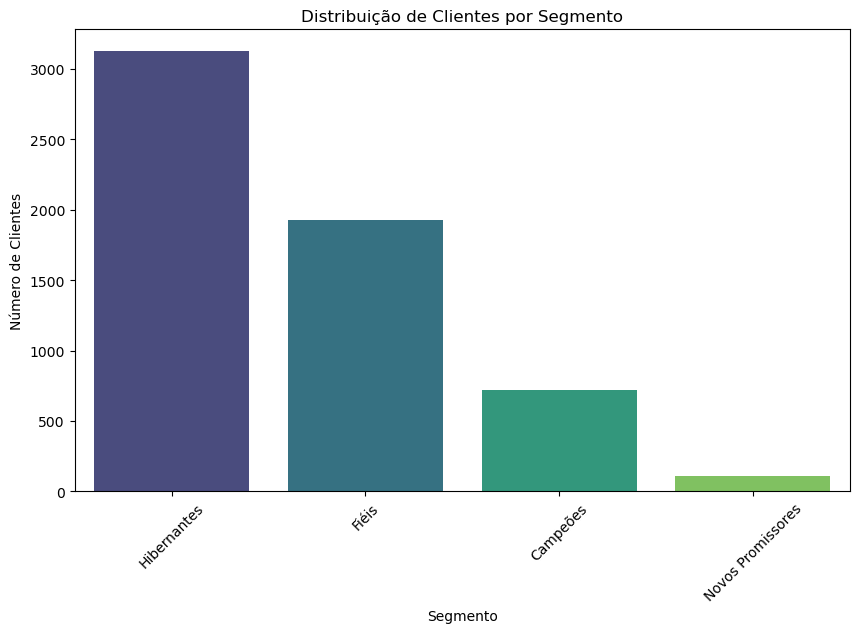

In [10]:
import seaborn as sns

# Contando quantos clientes tem em cada segmento
contagem_segmentos = rfm['Segmento'].value_counts()

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=contagem_segmentos.index, y=contagem_segmentos.values, palette='viridis')

plt.title('Distribuição de Clientes por Segmento')
plt.ylabel('Número de Clientes')
plt.xlabel('Segmento')
plt.xticks(rotation=45) # Gira o texto para ler melhor
plt.show()

In [11]:
# 1. Transformando as datas apenas para o formato "Ano-Mês" (ex: 2010-12)
def get_month(x): return pd.to_datetime(x).dt.to_period('M')

df['InvoiceMonth'] = get_month(df['InvoiceDate'])

# 2. Descobrindo o mês da PRIMEIRA compra de cada cliente (A "Coorte" dele)
# O transform('min') pega a menor data daquele cliente e repete em todas as linhas dele
df['CohortMonth'] = df.groupby('Customer ID')['InvoiceDate'].transform('min').dt.to_period('M')

print("Datas de coorte criadas!")
df[['Customer ID', 'InvoiceDate', 'InvoiceMonth', 'CohortMonth']].head()

Datas de coorte criadas!


,Customer ID,InvoiceDate,InvoiceMonth,CohortMonth
0,13085,2009-12-01 07:45:00,2009-12,2009-12
1,13085,2009-12-01 07:45:00,2009-12,2009-12
2,13085,2009-12-01 07:45:00,2009-12,2009-12
3,13085,2009-12-01 07:45:00,2009-12,2009-12
4,13085,2009-12-01 07:45:00,2009-12,2009-12


In [12]:
# Função para extrair ano e mês
def diff_month(x):
    d1 = x['InvoiceMonth']
    d2 = x['CohortMonth']
    return (d1.year - d2.year) * 12 + d1.month - d2.month

# Aplicando a conta
df['CohortIndex'] = df.apply(diff_month, axis=1)

print("Índices calculados! (0 = Mês de estreia, 1 = Mês seguinte...)")
df[['Customer ID', 'CohortMonth', 'InvoiceMonth', 'CohortIndex']].head()

Índices calculados! (0 = Mês de estreia, 1 = Mês seguinte...)


,Customer ID,CohortMonth,InvoiceMonth,CohortIndex
0,13085,2009-12,2009-12,0
1,13085,2009-12,2009-12,0
2,13085,2009-12,2009-12,0
3,13085,2009-12,2009-12,0
4,13085,2009-12,2009-12,0


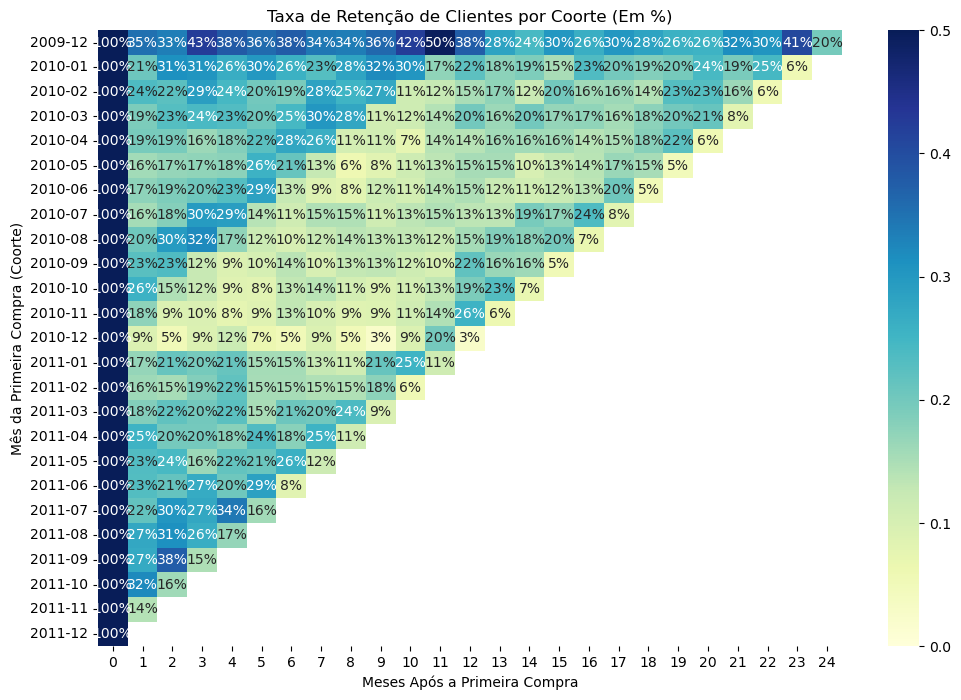

In [13]:
# 1. Criar a matriz: Linhas = Mês de Entrada | Colunas = Meses passados | Valores = Contagem de Clientes
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['Customer ID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Customer ID')

# 2. Transformar em PORCENTAGEM (Taxa de Retenção)
# Dividimos todos os meses pelo tamanho da coorte no mês 0 (tamanho inicial)
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

# 3. Plotar o Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
plt.title('Taxa de Retenção de Clientes por Coorte (Em %)')

# Criando o mapa de calor com anotações em %
sns.heatmap(retention, annot=True, fmt='.0%', cmap='YlGnBu', vmin=0.0, vmax=0.5)
# Nota: vmax=0.5 significa que cores escuras vão até 50%. Ajuste se necessário.

plt.ylabel('Mês da Primeira Compra (Coorte)')
plt.xlabel('Meses Após a Primeira Compra')
plt.show()